**Description:**

This is the Jupyter notebook is used to test a few classifier: Logistic regression, Naive Baise, KNN.??????

**Project Name:** Lending Club

**Team:** Silas Mederer, Jonas Bechthold

**Date:** 2020-10-02 to 2020-10-08

# Ensemble methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/df_clean.csv')
df.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41292 entries, 0 to 41291
Data columns (total 14 columns):
loan_amnt               41292 non-null float64
term_is_36              41292 non-null int64
int_rate                41292 non-null float64
grade                   41292 non-null object
sub_grade               41292 non-null object
emp_length              41292 non-null float64
annual_inc              41292 non-null float64
purpose                 41292 non-null object
addr_state              41292 non-null object
dti                     41292 non-null float64
inq_last_6mths          41292 non-null float64
open_acc                41292 non-null float64
pub_rec_bankruptcies    41292 non-null int64
default                 41292 non-null int64
dtypes: float64(7), int64(3), object(4)
memory usage: 4.4+ MB
None


## Upscaling of the minority class default = 1

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

There are several heuristics for doing so, but the most common way is to simply resample with replacement.

First, we'll import the resampling module from Scikit-Learn:

In [4]:
from sklearn.utils import resample

Next, we'll create a new DataFrame with an up-sampled minority class. Here are the steps:

First, we'll separate observations from each class into different DataFrames.
Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [5]:
df.default.value_counts()

0    35006
1     6286
Name: default, dtype: int64

In [7]:
# Separate majority and minority classes
df_majority = df[df.default==0]
df_minority = df[df.default==1]

majority_size = df_majority.shape[0]

print(majority_size)

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_size,    # to match majority class
                                 random_state=123) # reproducible results

df_minority_upsampled.columns

35006


Index(['loan_amnt', 'term_is_36', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'inq_last_6mths', 'open_acc', 'pub_rec_bankruptcies', 'default'],
      dtype='object')

In [9]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.default.value_counts()

1    35006
0    35006
Name: default, dtype: int64

In [10]:
df_upsampled.head()

,loan_amnt,term_is_36,int_rate,grade,sub_grade,emp_length,annual_inc,purpose,addr_state,dti,inq_last_6mths,open_acc,pub_rec_bankruptcies,default
0,5000.0,1,0.1065,B,B2,10.0,24000.0,credit_card,AZ,27.65,1.0,3.0,0,0
2,2400.0,1,0.1596,C,C5,10.0,12252.0,small_business,IL,8.72,2.0,2.0,0,0
3,10000.0,1,0.1349,C,C1,10.0,49200.0,other,CA,20.00,1.0,10.0,0,0
4,5000.0,1,0.0790,A,A4,3.0,36000.0,wedding,AZ,11.20,3.0,9.0,0,0
5,7000.0,0,0.1596,C,C5,8.0,47004.0,debt_consolidation,NC,23.51,1.0,7.0,0,0


In [11]:
df_upsampled.shape

(70012, 14)

In [12]:
df_upsampled.columns

Index(['loan_amnt', 'term_is_36', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'inq_last_6mths', 'open_acc', 'pub_rec_bankruptcies', 'default'],
      dtype='object')

## Create Dummies

In [13]:
cat_feats = ['grade','sub_grade','purpose','addr_state']

In [14]:
df = df_upsampled.copy()

In [15]:
df_final = pd.get_dummies(df, columns=cat_feats, drop_first=True)

In [16]:
df_final.head()

,loan_amnt,term_is_36,int_rate,emp_length,annual_inc,dti,inq_last_6mths,open_acc,pub_rec_bankruptcies,default,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,5000.0,1,0.1065,10.0,24000.0,27.65,1.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,1,0.1596,10.0,12252.0,8.72,2.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,1,0.1349,10.0,49200.0,20.00,1.0,10.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5000.0,1,0.0790,3.0,36000.0,11.20,3.0,9.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7000.0,0,0.1596,8.0,47004.0,23.51,1.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_final.shape

(70012, 112)

## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

X = df_final.drop('default', axis=1)
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Scaling

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaling_list = ["dti", "int_rate", "loan_amnt","annual_inc"]
scaling_min_max = ["annual_inc"]

def logarithmize(value):
    #print(value)
    logvalue = np.log(value)
    return logvalue

# scaling train
X_train[scaling_min_max] = X_train[scaling_min_max].apply(lambda x: logarithmize(x))
X_train[scaling_list] = scaler.fit_transform(X_train[scaling_list])

# scaling test with same scaling parameters
X_test[scaling_min_max] = X_test[scaling_min_max].apply(lambda x: logarithmize(x))
X_test[scaling_list] = scaler.transform(X_test[scaling_list])

/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

<AxesSubplot:>

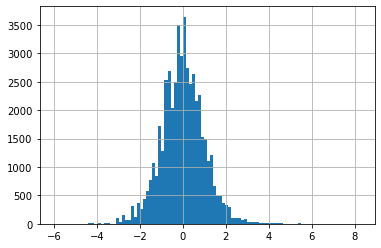

In [20]:
X_train.annual_inc.hist(bins=100)

<AxesSubplot:>

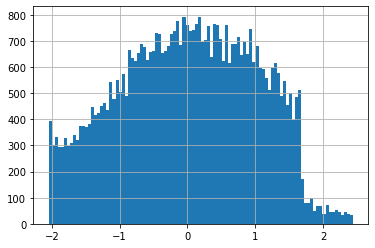

In [21]:
X_train.dti.hist(bins=100)

<AxesSubplot:>

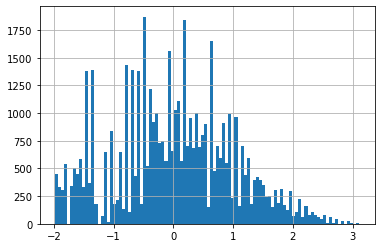

In [22]:
X_train.int_rate.hist(bins=100)

<AxesSubplot:>

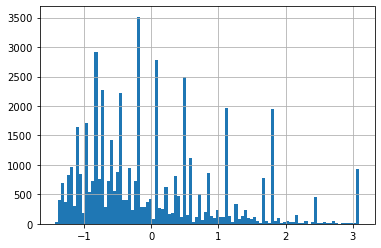

In [23]:
X_train.loan_amnt.hist(bins=100)

# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
dtree = DecisionTreeClassifier(max_depth=5)

In [34]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [35]:
predictions = dtree.predict(X_test)
train_predictions = dtree.predict(X_train)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60     10501
           1       0.62      0.73      0.67     10503

    accuracy                           0.64     21004
   macro avg       0.64      0.64      0.64     21004
weighted avg       0.64      0.64      0.64     21004



In [38]:
print(confusion_matrix(y_test, predictions))

[[5752 4749]
 [2831 7672]]


In [39]:
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61     24505
           1       0.62      0.74      0.67     24503

    accuracy                           0.64     49008
   macro avg       0.65      0.64      0.64     49008
weighted avg       0.65      0.64      0.64     49008



In [40]:
print(confusion_matrix(y_train, train_predictions))

[[13589 10916]
 [ 6492 18011]]


# Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rnc = RandomForestClassifier()

In [43]:
rnc.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
pred_train = rnc.predict(X_train)

In [45]:
pred_test = rnc.predict(X_test)

In [46]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24505
           1       1.00      1.00      1.00     24503

    accuracy                           1.00     49008
   macro avg       1.00      1.00      1.00     49008
weighted avg       1.00      1.00      1.00     49008



In [47]:
print(confusion_matrix(y_train, pred_train))

[[24504     1]
 [    0 24503]]


In [48]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10501
           1       0.95      0.98      0.97     10503

    accuracy                           0.97     21004
   macro avg       0.97      0.97      0.97     21004
weighted avg       0.97      0.97      0.97     21004



In [49]:
print(confusion_matrix(y_test, pred_test))

[[ 9964   537]
 [  190 10313]]


## Random Forest with Stacking

In [52]:
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(RandomForestClassifier(random_state=42))

clf.fit(X_train, y_train)

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [ ]:
Comparison of results

## Random Forest Optimization through RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 500).astype(int),
    'max_depth': [None] + list(np.linspace(3, 100).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier()

# Create the random search model
rnc = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'recall', cv = 3, 
                        n_iter = 20, verbose = 1)

# Fit 
rnc.fit(X_train, y_train)

In [ ]:
best_model = rnc.best_estimator_

In [ ]:
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_probs = best_model.predict_proba(X_test)[:, 1]

In [ ]:
print(confusion_matrix(y_test, rf_predictions))

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# XGBoost

In [53]:
from xgboost import XGBClassifier

XGBoot [booster = gbtree] -> uses a tree model
max_dept = 6 -> depth of the tree used
n_estimator = number of trees

Parameters

max_depth : int
    Maximum tree depth for base learners.
    
learning_rate : float
    Boosting learning rate (xgb's "eta")
    
n_estimators : int
    Number of trees to fit.
    
verbosity : int
    The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    

In [54]:
# fit model no training data
model = XGBClassifier(n_estimators=200)
model.fit(X_train, y_train)

XGBClassifier(n_estimators=200)

In [55]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [56]:
print(confusion_matrix(y_test, y_pred))

[[6989 3512]
 [3410 7093]]


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67     10501
           1       0.67      0.68      0.67     10503

    accuracy                           0.67     21004
   macro avg       0.67      0.67      0.67     21004
weighted avg       0.67      0.67      0.67     21004



In [58]:
print(confusion_matrix(y_train, y_pred_train))

[[16583  7922]
 [ 7589 16914]]


In [59]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68     24505
           1       0.68      0.69      0.69     24503

    accuracy                           0.68     49008
   macro avg       0.68      0.68      0.68     49008
weighted avg       0.68      0.68      0.68     49008



## XGBoost Optimization

In [ ]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

clf_xgb = XGBClassifier(objective = 'binary:logistic')

param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 5,  
                         n_iter = 5,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train, y_train)

best_score = clf.best_score_
best_params = clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


# AdaBoost

In [60]:
from sklearn.ensemble import AdaBoostClassifier

# fit model no training data
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state = 101)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_train, y_pred_train))

print(classification_report(y_train, y_pred_train))

[[ 9644   857]
 [  199 10304]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     10501
           1       0.92      0.98      0.95     10503

    accuracy                           0.95     21004
   macro avg       0.95      0.95      0.95     21004
weighted avg       0.95      0.95      0.95     21004

[[24504     1]
 [    0 24503]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24505
           1       1.00      1.00      1.00     24503

    accuracy                           1.00     49008
   macro avg       1.00      1.00      1.00     49008
weighted avg       1.00      1.00      1.00     49008



## AdaBoost RandomizedSearchCV

In [ ]:
ada = AdaBoostClassifier(random_state=42)
parameters = {'n_estimators':[500, 1000, 1500, 2000], 
              'learning_rate':[0.05, 0.1, 0.15, 0.2]}

scorer = make_scorer(f1_score)
ada_obj = RandomizedSearchCV(ada, 
                            parameters, 
                            scoring = 'recall', 
                            cv = 5,
                            random_state=42)
ada_fit = ada_obj.fit(X_train, y_train)
ada_opt = ada_fit.best_estimator_

## AdaBoost Optimization

In [61]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score

# TODO: Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.2, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 10, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=1.0) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=1.0) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


KeyboardInterrupt: 